In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range

import random
# import seaborn as sns
# sns.set_style("darkgrid")

import matplotlib.pyplot as plt
# plot param
%matplotlib inline
plt.rcParams['figure.figsize'] = (22.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ggplot')
# plt.style.use('seaborn')

from livelossplot import PlotLosses
from time import sleep

In [2]:
det = True

In [4]:
f = open("../../controllers/dcdc/combined_sampled.scs", "r")

In [5]:
state_dim = 2
input_dim = 1

In [6]:
lines = []

In [7]:
lines = f.readlines()

In [8]:
for line in f: # now you are at the lines you want
    # skip the #BEGIN 
    # read the state-actions
    lines = f.readlines()

In [9]:
# take the state as the train dataset
ltrain_dataset = []
for x in lines:
    ltrain_dataset.append(x.split(' ')[0:state_dim])
# del ltrain_dataset[-1] # delete the string #END at the end of the file 

In [10]:
# convert to the numpy array with float32 data type
train_dataset = np.asarray(ltrain_dataset)
train_dataset = train_dataset.astype(np.float32)

In [11]:
train_dataset

array([[87.,  1.],
       [88.,  1.],
       [89.,  1.],
       ...,
       [81., 99.],
       [82., 99.],
       [83., 99.]], dtype=float32)

In [12]:
upper_limit = train_dataset.shape[0]
num_samples = upper_limit

In [13]:
# train_dataset_int = (train_dataset/eta).astype(np.uint32)
train_dataset_int = (train_dataset).astype(np.uint32)

In [14]:
train_dataset_int

array([[87,  1],
       [88,  1],
       [89,  1],
       ...,
       [81, 99],
       [82, 99],
       [83, 99]], dtype=uint32)

In [15]:
train_dataset_int.shape

(8677, 2)

In [16]:
X1, X2 = train_dataset_int[:,0], train_dataset_int[:,1]

In [17]:
np.max(X1)

99

In [18]:
np.max(X2)

99

In [19]:
msb1 = len(bin(int(np.max(X1))))-2

In [20]:
msb2 = len(bin(int(np.max(X2))))-2

In [21]:
msb1

7

In [22]:
msb2

7

In [23]:
swapped = np.concatenate((X2[:, None],X1[:, None]), axis=1)

In [24]:
swapped

array([[ 1, 87],
       [ 1, 88],
       [ 1, 89],
       ...,
       [99, 81],
       [99, 82],
       [99, 83]], dtype=uint32)

In [25]:
train_dataset_int8 = swapped.view(np.uint8)
train_dataset_int8

array([[ 1,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       [ 1,  0,  0, ...,  0,  0,  0],
       ...,
       [99,  0,  0, ...,  0,  0,  0],
       [99,  0,  0, ...,  0,  0,  0],
       [99,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [26]:
train_dataset_int8.shape

(8677, 8)

In [27]:
tdi_ordered = np.flip(train_dataset_int8,1)
tdi_ordered

array([[ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  1],
       ...,
       [ 0,  0,  0, ...,  0,  0, 99],
       [ 0,  0,  0, ...,  0,  0, 99],
       [ 0,  0,  0, ...,  0,  0, 99]], dtype=uint8)

In [28]:
tdi_ordered[0]

array([ 0,  0,  0, 87,  0,  0,  0,  1], dtype=uint8)

In [29]:
total_bit = 32

In [30]:
tdio_unpacked = np.unpackbits(tdi_ordered).reshape(-1,total_bit*state_dim)

In [31]:
tdio_unpacked[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
      dtype=uint8)

In [32]:
total_bit - msb1

25

In [33]:
total_bit - msb2

25

In [34]:
reduced = np.concatenate((np.arange(total_bit-msb1, total_bit), np.arange(state_dim*total_bit-msb2, state_dim*total_bit)) )

In [35]:
tdio_reduced = tdio_unpacked[:,reduced]

In [36]:
tdio_reduced.shape

(8677, 14)

In [37]:
tdio_unpacked[0][:32]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1], dtype=uint8)

In [38]:
tdio_unpacked[0][32:]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1], dtype=uint8)

In [39]:
tdio_unpacked

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 1, 1]], dtype=uint8)

In [40]:
# take action/label pair of the state 
# take the action(s) [column 1:-1] / the rest of the integer except the state
ltrain_label = []
for x in lines:
    if det == False:
        ltrain_label.append(x.strip().split()[state_dim:])
    else:
        ltrain_label.append(x.strip().split()[state_dim])
# del ltrain_label[-1] # delete the string #END at the end of the file  

# convert to numpy array, note that the result is still not in one hot encoding format
train_label = np.asarray(ltrain_label)

In [41]:
train_label

array(['2', '2', '2', ..., '1', '1', '1'], dtype='<U1')

In [42]:
if det == False:
    # select to use ND or D case here
    # create now array to be filled by the encoded label
    train_label_int = [[int(i) for i in l] for l in ltrain_label]
    action_setlist = sorted(set(x for l in train_label_int for x in l))
    num_label = len(action_setlist)
    train_label_hot = np.zeros([num_samples, num_label], dtype=np.float32)
    for i,actions in enumerate(train_label_int):
        for action in actions:
            train_label_hot[i, action_setlist.index(action)] = 1
else:
    train_label_hot = train_label[:, None].astype(np.uint8)
    train_label = train_label[:, None].astype(np.uint8)

In [43]:
train_label

array([[2],
       [2],
       [2],
       ...,
       [1],
       [1],
       [1]], dtype=uint8)

In [44]:
train_label.shape

(8677, 1)

In [45]:
train_dataset = tdio_reduced # tdio_unpacked

In [46]:
train_dataset.shape

(8677, 14)

In [47]:
def accuracy_softmax(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

def accuracy_multilabel(predictions, labels):
  return (100.0 * np.mean(predictions == labels))

def accuracy_multilabel_softmax(predictions, labels):
    predictions_soft = np.zeros_like(predictions)
    predictions_soft[np.arange(len(predictions)), predictions.argmax(1)] = 1
    return (100.0*np.mean(labels[np.arange(len(labels)), predictions_soft.argmax(1)]))

def accuracy_real_value(predictions, labels):
    return (100*np.mean(predictions.round() == batch_labels))


In [48]:
tf.reset_default_graph()
batch_size = 1024 #  num_samples # (num_samples//20) # 113*6 # num_samples
num_batches = np.ceil(num_samples/batch_size)

In [49]:
train_label

array([[2],
       [2],
       [2],
       ...,
       [1],
       [1],
       [1]], dtype=uint8)

In [50]:
num_label = train_label.shape[1]
input_size = train_dataset.shape[1]

In [51]:
input_size

14

In [52]:
num_label

1

In [53]:
print(batch_size)
print(num_batches)

1024
9.0


In [54]:
hidden_size = 6
hidden_size2 = 4

# with tf.device('/device:GPU:0'):
# Input data. For the training data, we use a placeholder that will be fed
# at run time with a training minibatch.
# tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, input_size))
# tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_label))
tf_train_dataset = tf.placeholder(tf.float32, shape=(None, input_size))
tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_label))
dropout_prob = tf.placeholder(tf.float32)

# Variables.
weights1 = tf.Variable(tf.truncated_normal([input_size, hidden_size]))
biases1 = tf.Variable(tf.zeros([hidden_size]))

# weights2 = tf.Variable(tf.truncated_normal([hidden_size, num_label]))
# biases2 = tf.Variable(tf.zeros([num_label]))

weights2 = tf.Variable(tf.truncated_normal([hidden_size, hidden_size2]))
biases2 = tf.Variable(tf.zeros([hidden_size2]))

weights3 = tf.Variable(tf.truncated_normal([hidden_size2, num_label]))
biases3 = tf.Variable(tf.zeros([num_label]))

"""
# weights4 = tf.Variable(tf.truncated_normal([hidden_size3, num_label]))
# biases4 = tf.Variable(tf.zeros([num_label]))
weights4 = tf.Variable(tf.truncated_normal([hidden_size3, hidden_size4]))
biases4 = tf.Variable(tf.zeros([hidden_size4]))

weights5 = tf.Variable(tf.truncated_normal([hidden_size4, num_label]))
biases5 = tf.Variable(tf.zeros([num_label]))
"""

# Training computation.
logits1 = tf.matmul(tf_train_dataset, weights1) + biases1  
relu_act_func_d = tf.nn.relu(logits1)
relu_act_func = tf.nn.dropout(relu_act_func_d, dropout_prob)

logits2 = tf.matmul(relu_act_func, weights2) + biases2
relu_act_func2_d = tf.nn.relu(logits2)
relu_act_func2 = tf.nn.dropout(relu_act_func2_d, dropout_prob)

logits3 = tf.matmul(relu_act_func2, weights3) + biases3

"""
relu_act_func3 = tf.nn.relu(logits3)
logits4 = tf.matmul(relu_act_func3, weights4) + biases4

relu_act_func4 = tf.nn.relu(logits4)
logits5 = tf.matmul(relu_act_func4, weights5) + biases5
"""

logits = logits3
# train_prediction = tf.round(tf.sigmoid(logits))
# train_prediction = (tf.nn.softmax(logits))
train_prediction = tf.round(logits)

# loss calculation
# loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_train_labels, logits=logits))
# loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf_train_labels, logits=logits))
loss = tf.losses.mean_squared_error(labels = tf_train_labels, predictions =  logits)

loss_summary = tf.summary.scalar('loss', loss)
# optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)
optimizer = tf.train.AdamOptimizer(0.0015).minimize(loss)


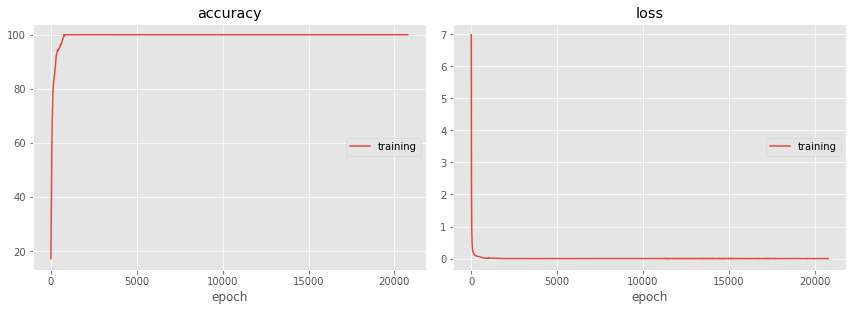

Epoch: 20786, Loss: 0.000268, Accuracy: 99.96%


KeyboardInterrupt: 

In [55]:
loss_history = []
acc_history = []
liveplot = PlotLosses()

acc = 0
acc_cum = 0
acc_temp = 0
epoch_idx = 0
loss_disp_true = False
loss_avg = 0.0
old_loss_avg = 0.0
loss_cum = 0.0
need_one_more_iteration = True

early_stop_loss_counter = 0
not_early_stop = True

with tf.Session() as session:
# with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as session:
# with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    while (((acc < 100) or need_one_more_iteration) and not_early_stop):
        if (acc >= 100):
            need_one_more_iteration = False
        else:
            need_one_more_iteration = True
            
        epoch_idx += 1
        acc_cum = 0
        for step in range(int(num_batches)):
            # Pick an offset within the training data, which has been randomized.
            # Note: we could use better randomization across epochs.
        
            offset = (step * batch_size)
            
            if num_samples > offset + batch_size:
                batch_limit = offset + batch_size
            else:
                batch_limit = num_samples
                loss_disp_true = True
                       
            # offset = np.random.randint(num_samples - batch_size , size = 1)[0]
            # Generate a minibatch.
            batch_data = train_dataset[offset:(batch_limit), :]
            batch_labels = train_label[offset:(batch_limit), :]

            # print(offset)
            # Prepare a dictionary telling the session where to feed the minibatch.
            # The key of the dictionary is the placeholder node of the graph to be fed,
            # and the value is the numpy array to feed to it.
            feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, dropout_prob : 1}
            _, l, predictions, added_summary, logits_check = session.run(
                [optimizer, loss, train_prediction, loss_summary, logits], feed_dict=feed_dict)

            # writer.add_summary(added_summary)
            # acc_temp =  accuracy_multilabel_softmax(predictions, batch_labels)
            acc_temp = accuracy_real_value(predictions, batch_labels)
            acc_cum += acc_temp
            acc = acc_cum/(step+1)
            loss_cum += l
            if loss_disp_true:
                loss_disp_true = False
                loss_avg = loss_cum/num_batches
                loss_cum = 0
                loss_history.append(loss_avg)
                acc_history.append(acc)
                liveplot.update({
                    'accuracy': acc,
                    # 'val_accuracy': 1 - np.random.rand() / (i + 0.5),
                    'loss': loss_avg,
                    # 'val_mse': 1. / (i + 0.5)
                })
                liveplot.draw()
                print("Epoch:{0:6d}, Loss: {1:8.6f}, Accuracy:{2:6.2f}%".format(epoch_idx, loss_avg, acc))
                
                if loss_avg == old_loss_avg:
                    print('stagnan')
                    early_stop_loss_counter += 1
                    if early_stop_loss_counter == 100:
                        not_early_stop = False
                    
                old_loss_avg = loss_avg
                # sleep(0.1)
                # print("Epoch {0:6d} batch_limit: {1:6d} Loss: {2:8.4f} Training Acc: {3:8.2f} {4:8.2f} {5:8.2f}%".format(epoch_idx, batch_limit, l, acc_temp, acc_cum, acc))
                    
    # Do for the test batch
    acc = 0
    acc_cum = 0
    for step in range(int(num_batches)):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) #  % (train_label_hot.shape[0] - batch_size)
        
        if num_samples > offset + batch_size:
            batch_limit = offset + batch_size
        else:
            batch_limit = num_samples
            loss_disp_true = True

        batch_data = train_dataset[offset:(batch_limit), :]
        batch_labels = train_label[offset:(batch_limit), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels, dropout_prob : 1}
        test_predictions = session.run(train_prediction, feed_dict=feed_dict)
        # batch_acc = accuracy_multilabel_softmax(test_predictions, batch_labels)
        batch_acc = accuracy_real_value(test_predictions, batch_labels)
        acc_cum = acc_cum + batch_acc
        acc = acc_cum/(step+1)
        
        print("batch_limit {0:6d} Training Acc: {1:8.2f} {2:8.2f} {3:8.2f}%".format(batch_limit, batch_acc, acc_cum, acc))

    print(acc)
    
    weight1_eval = weights1.eval()
    bias1_eval = biases1.eval()
    
    weight2_eval = weights2.eval()
    bias2_eval = biases2.eval()
    
    weight3_eval = weights3.eval()
    bias3_eval = biases3.eval()
    

In [58]:
batch_labels

array([[1],
       [1],
       [1],
       ...,
       [2],
       [2],
       [2]], dtype=uint8)

In [59]:
predictions

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [57]:
weight1_eval

NameError: name 'weight1_eval' is not defined

In [105]:
np.savetxt('weight1.txt', weight1_eval)

In [106]:
np.savetxt('weight2.txt', weight2_eval)

In [107]:
np.savetxt('weight3.txt', weight3_eval)

In [104]:
weight1_eval

array([[ 2.80228615e+00,  1.78102922e+00,  2.32262993e+00,
        -8.56397033e-01, -5.22910595e-01,  1.79409111e+00,
         4.74167705e-01,  1.81067276e+00,  1.46275729e-01,
         1.33950442e-01],
       [-3.78352739e-02,  1.04149663e+00, -1.32448509e-01,
         1.94813907e-02, -5.26818931e-01, -1.52444100e+00,
        -2.37543732e-01, -3.22714972e+00, -5.55115759e-01,
        -4.29306887e-02],
       [ 1.65371799e+00,  4.34007913e-01, -7.31636882e-02,
         6.52212560e-01,  1.46574333e-01,  2.09892797e+00,
        -1.51709124e-01,  2.25218725e+00,  1.76776898e+00,
         1.47465324e+00],
       [-9.13890600e-01,  7.85113499e-02, -1.03686595e+00,
         2.17201471e+00,  2.01045170e-01, -4.97353524e-01,
        -9.33219194e-01,  1.23070967e+00,  1.39099443e+00,
        -1.48591280e+00],
       [-1.46289602e-01,  6.33503556e-01, -4.38586444e-01,
         3.34595346e+00,  1.86944038e-01, -3.93787652e-01,
        -1.09892249e+00,  1.88407153e-01,  6.31081879e-01,
        -1.

In [92]:
np.mean(batch_labels == predictions)

1.0

In [93]:
weight1_eval.shape

(14, 10)

In [94]:
weight2_eval.shape

(10, 5)

In [95]:
weight3_eval.shape

(5, 1)

In [ ]:
acc_history[-10:]

In [ ]:
hidden = str(hidden_size)+str(hidden_size2)

In [ ]:
plt.plot(loss_history, 'r', training_history[:len(loss_history),1], 'b')

In [ ]:
plt.plot(acc_history, 'r', training_history[:len(loss_history),2], 'b')

In [ ]:
plt.rcParams['figure.figsize'] = (18.0, 8.0)
plt.plot(loss_history)
fig = plt.gcf()
fig.savefig(f.name[:-4]+hidden+'nd_loss.png', dpi = 200)
fig = plt.gcf()
plt.show()
plt.draw()


In [ ]:
plt.plot(acc_history)
fig.savefig(f.name[:-4]+hidden+'nd_acc.png', dpi = 200)
fig = plt.gcf()
plt.show()
plt.draw()


In [ ]:
lh_array = np.array(loss_history)[:, np.newaxis]

In [ ]:
ah_array = np.array(acc_history)[:, np.newaxis]

In [ ]:
ei_array = np.arange(epoch_idx, dtype=object)[:, np.newaxis]

In [ ]:
training_history = np.concatenate((ei_array, lh_array, ah_array), axis = 1)

In [ ]:
np.savetxt(f.name[:-4]+hidden+'d_small_test.csv', training_history, delimiter=",")